<a href="https://colab.research.google.com/github/bolaris-sage/shark-figures/blob/main/shark-figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook presents an in-depth analysis of white shark movement data, with a focus on understanding the relationship between depth and Overall Dynamic Body Acceleration (ODBA) over time. Utilizing a rich dataset, the study aims to decipher patterns in shark behavior and energy expenditure. Through a combination visualization and analytical techniques, we explore how these magnificent creatures interact with their aquatic environment. Our findings have potential implications for marine biology, conservation efforts, and the broader ecological understanding of shark behaviors in their natural habitat.

## Data Overview

- **Comment**: CEFAS 1 Female 4.5
- **Tag ID**: A14243
- **Firmware**: Version 3, Build Level 70
- **Pressure Range**: 50 units
- **Sensors Count**: 5
- **Deployment Duration**: October 15, 2017, to November 30, 2017

**Mission Parameters**
- **Dive Termination**: 1.5% percentage, 7.5m depth
- **Gravity Range**: 2g
- **Operational Days**: 51

**Data Sampling**
- **Logging Rate**: 1 per minute
- **Resolution**: 12 bits

The dataset contains time-stamped measurements of pressure, temperature, and tri-axial acceleration. These metrics are used to assess the shark's movement behavior.

# Analysis

## Import Libraries

In [1]:
# Install Astral (if needed)
%pip install astral

# Standard library imports
import os
import sys

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
from astral import LocationInfo
from astral.sun import sun, dawn, dusk

Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [2]:
# Check if the notebook is running on Google Colab
running_on_colab = 'google.colab' in sys.modules

if running_on_colab:
    # Google Colab specific imports
    from google.colab import auth, drive

    # Authenticate and mount the drive
    auth.authenticate_user()
    drive.mount('/content/drive')
    
    # Set the base path for data on Google Drive
    base_path = '/content/drive/MyDrive/shark-data/'
else:
    # Set the base path for local data
    base_path = 'C:/shared/shark-data/'

# Now you can load your data using the base path
boats_data_path = os.path.join(base_path, 'baby-shark-data-boats.csv')
odba_data_path = os.path.join(base_path, 'baby-shark-data-odba.csv')

boats_data = pd.read_csv(boats_data_path)
odba_data = pd.read_csv(odba_data_path)

## Data Preparation

In [3]:

# Prepare the data for each plot
# Load your dataset (assuming odba_data and boats_data are loaded elsewhere in the code)

# 1. ODBA vs Time of Day (Bar Graph with Error Bars)
odba_time_of_day = odba_data.groupby('Time of Day')['ODBA (g)'].agg(['mean', 'sem'])

# 2. ODBA vs Depth (Bar Graph with Error Bars, categorized in 30m increments with labeled intervals)
# Define depth intervals and labels
depth_intervals = np.arange(0, max(odba_data['Pressure (m)']) + 30, 30)
depth_labels = [f"{int(i)}-{int(j)}" for i, j in zip(depth_intervals[:-1], depth_intervals[1:])]

# Create a 'Depth Category' column with labeled intervals
odba_data['Depth Category'] = pd.cut(odba_data['Pressure (m)'], bins=depth_intervals, labels=depth_labels)

# Group data by 'Depth Category' and calculate mean and standard error of ODBA
odba_depth = odba_data.groupby('Depth Category', observed=True)['ODBA (g)'].agg(['mean', 'sem'])

# 3. ODBA vs Number of Boats (Scatter Plot)
boats_data.rename(columns={'ODBA (g)': 'ODBA'}, inplace=True)

# 4. ODBA vs Time (Continuous Scatter Plot with Time of Day Bands)
odba_data['Time'] = pd.to_datetime(odba_data['Time Stamp'])

### Calculating Day-Night Cycle Times

In [4]:
from astral import LocationInfo
from astral.sun import sun, dawn, dusk
from pytz import timezone
import pandas as pd

# Define the location and timezone for sunrise/sunset calculations
# Guadalupe Island Coordinates
latitude = 29.020879
longitude = -118.273103
city = LocationInfo('Ensenada', 'Mexico', 'America/Tijuana', latitude, longitude)
local_tz = timezone('America/Tijuana')
observer = city.observer

# Function to calculate sunrise, sunset, and nautical twilight times
def calculate_sun_times(date):
    """Calculate sun times for a given date."""
    sun_times = sun(observer, date=date, tzinfo=local_tz)
    nautical_dawn = dawn(observer, date=date, tzinfo=local_tz)
    nautical_dusk = dusk(observer, date=date, tzinfo=local_tz)
    
    # Return times as timezone-naive datetime objects
    return {
        'nautical_dawn': nautical_dawn.replace(tzinfo=None),
        'sunrise': sun_times['sunrise'].replace(tzinfo=None),
        'sunset': sun_times['sunset'].replace(tzinfo=None),
        'nautical_dusk': nautical_dusk.replace(tzinfo=None)
    }

def plot_day_night_bands(sun_times_per_date, odba_data, ax):
    """
    Plot day and night bands on the given matplotlib axis.
    """
    # Define colors and transparency for each period
    time_periods = {
        'Night': {'color': 'black', 'alpha': 0.05},
        'Dawn': {'color': 'red', 'alpha': 0.15},
        'Day': {'color': 'yellow', 'alpha': 0.15},
        'Dusk': {'color': 'orange', 'alpha': 0.2},
    }

    # Get the overall time range of the data
    data_start = odba_data['Time Stamp'].min()
    data_end = odba_data['Time Stamp'].max()

    # Keep track of labels already added to avoid duplicates in the legend
    labels_plotted = set()

    # Build a list of intervals to plot
    intervals = []
    dates = sorted(sun_times_per_date.keys())

    # Add initial Night interval before the first nautical dawn
    first_nautical_dawn = sun_times_per_date[dates[0]]['nautical_dawn']
    if data_start < first_nautical_dawn:
        intervals.append((data_start, first_nautical_dawn, 'Night'))

    # Create intervals for each date
    for i, date in enumerate(dates):
        times = sun_times_per_date[date]
        nautical_dawn = times['nautical_dawn']
        sunrise = times['sunrise']
        sunset = times['sunset']
        nautical_dusk = times['nautical_dusk']

        # Dawn
        intervals.append((nautical_dawn, sunrise, 'Dawn'))
        # Day
        intervals.append((sunrise, sunset, 'Day'))
        # Dusk
        intervals.append((sunset, nautical_dusk, 'Dusk'))

        # Night between nautical dusk and next day's nautical dawn
        if i < len(dates) - 1:
            next_nautical_dawn = sun_times_per_date[dates[i + 1]]['nautical_dawn']
            intervals.append((nautical_dusk, next_nautical_dawn, 'Night'))
        else:
            # Last date: extend to data_end
            if nautical_dusk < data_end:
                intervals.append((nautical_dusk, data_end, 'Night'))

    # Plot the intervals
    for start, end, period in intervals:
        # Ensure the interval is within the data's time range
        start = max(start, data_start)
        end = min(end, data_end)
        if start < end:
            ax.axvspan(
                start,
                end,
                color=time_periods[period]['color'],
                alpha=time_periods[period]['alpha'],
                label=period if period not in labels_plotted else ""
            )
            labels_plotted.add(period)

    # Add legend to the plot
    ax.legend(loc='upper left', fontsize=18)

# Convert 'Time Stamp' to timezone-naive datetime
odba_data['Time Stamp'] = pd.to_datetime(odba_data['Time Stamp']).dt.tz_localize(None)

# Extract the date from 'Time Stamp'
odba_data['Date'] = odba_data['Time Stamp'].dt.date

# Calculate sun times for each unique date in the data
sun_times_per_date = {
    date: calculate_sun_times(date) for date in odba_data['Date'].unique()
}

## Plotting

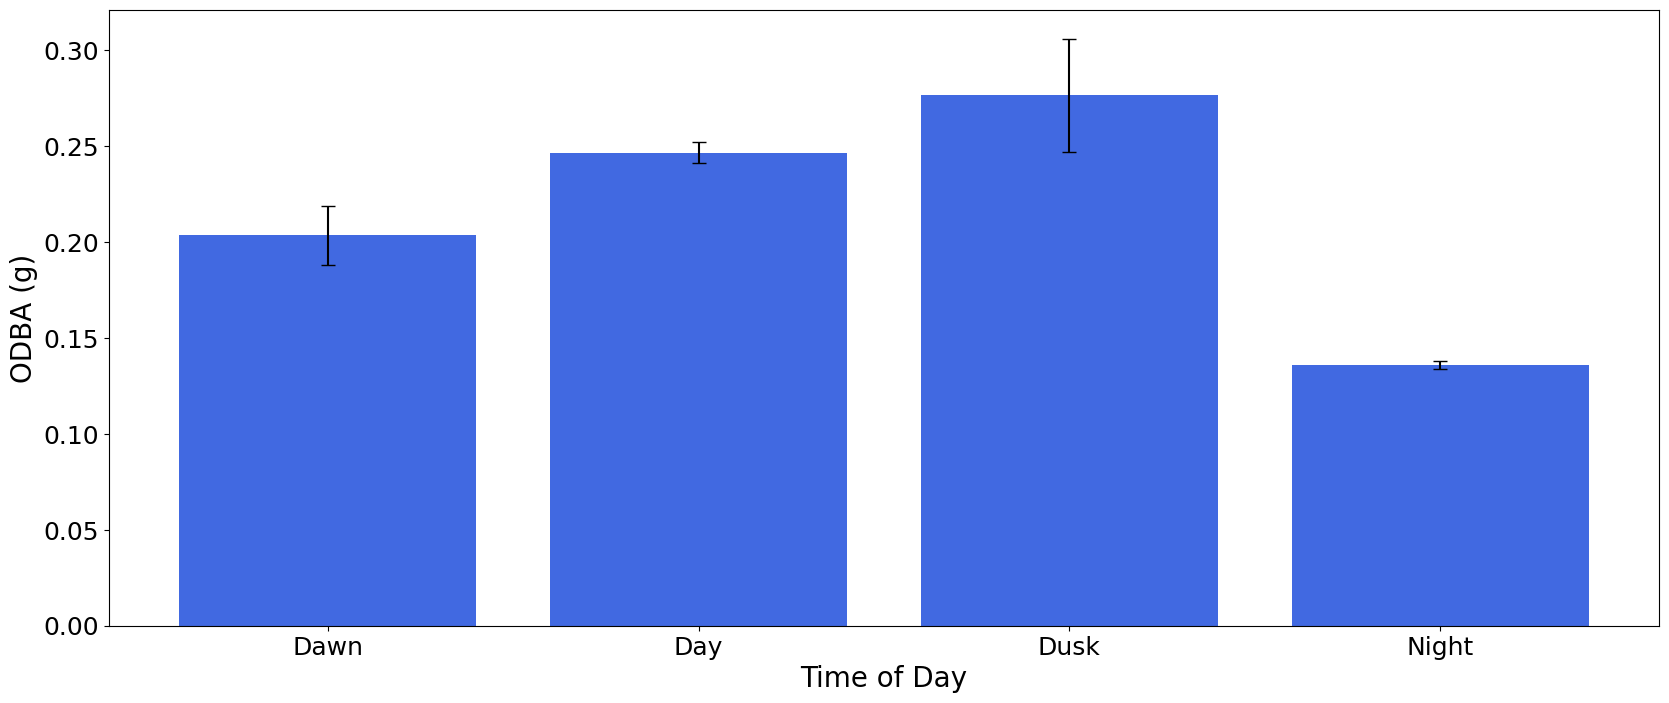

In [5]:
# 1. ODBA vs Time of Day
plt.figure(figsize=(20, 8))
plt.bar(odba_time_of_day.index, odba_time_of_day['mean'], yerr=odba_time_of_day['sem'], capsize=5, color='royalblue')
plt.xlabel('Time of Day', fontsize=20)
plt.ylabel('ODBA (g)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('ODBA vs Time of Day with Error Bars (+/- 1 SEM)')
plt.show()

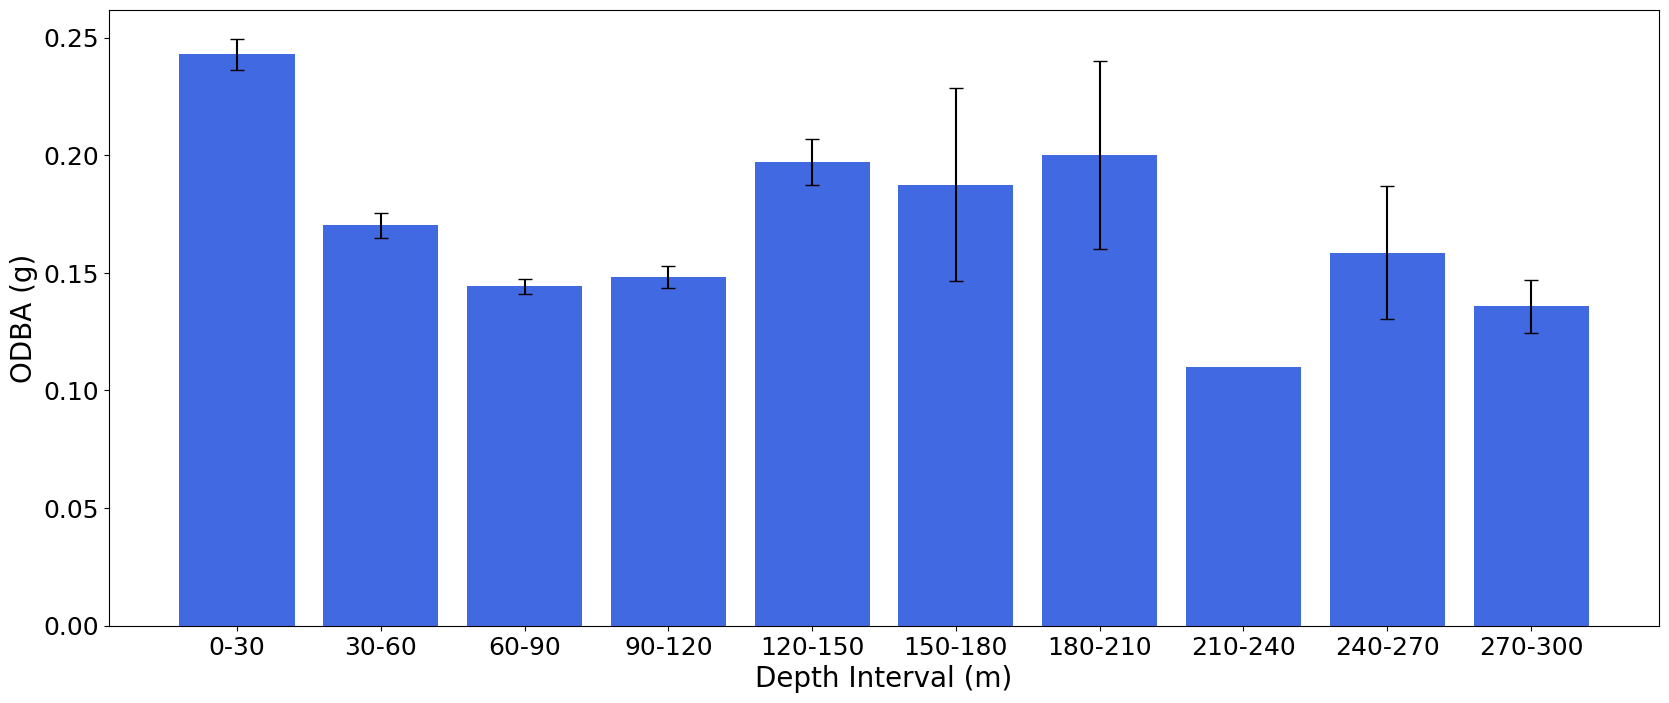

In [6]:
# 2. ODBA vs Depth (categorized in 30m increments with labeled intervals)
plt.figure(figsize=(20, 8))
plt.bar(odba_depth.index, odba_depth['mean'], yerr=odba_depth['sem'], capsize=5, color='royalblue')
plt.xlabel('Depth Interval (m)', fontsize=20)
plt.ylabel('ODBA (g)', fontsize=20)
#plt.title('ODBA vs Depth (30m Increments) with Error Bars (+/- 1 SEM)')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

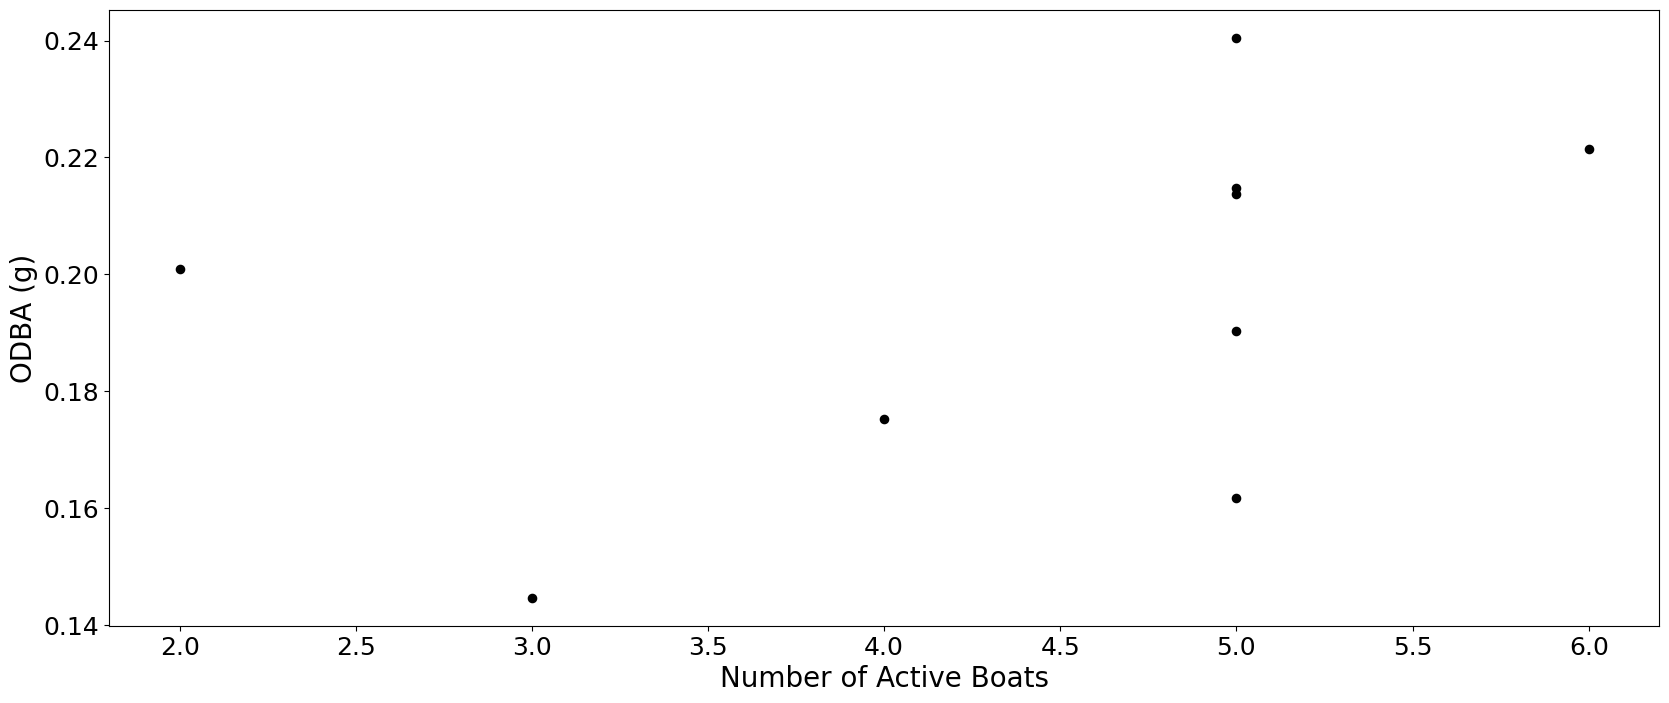

In [7]:
# 3. ODBA vs Number of Boats
plt.figure(figsize=(20, 8))
plt.scatter(boats_data['# of Active Boats'], boats_data['ODBA'], color='black', alpha=1, s=35)
plt.xlabel('Number of Active Boats', fontsize=20)
plt.ylabel('ODBA (g)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title('ODBA vs Number of Boats')
plt.show()

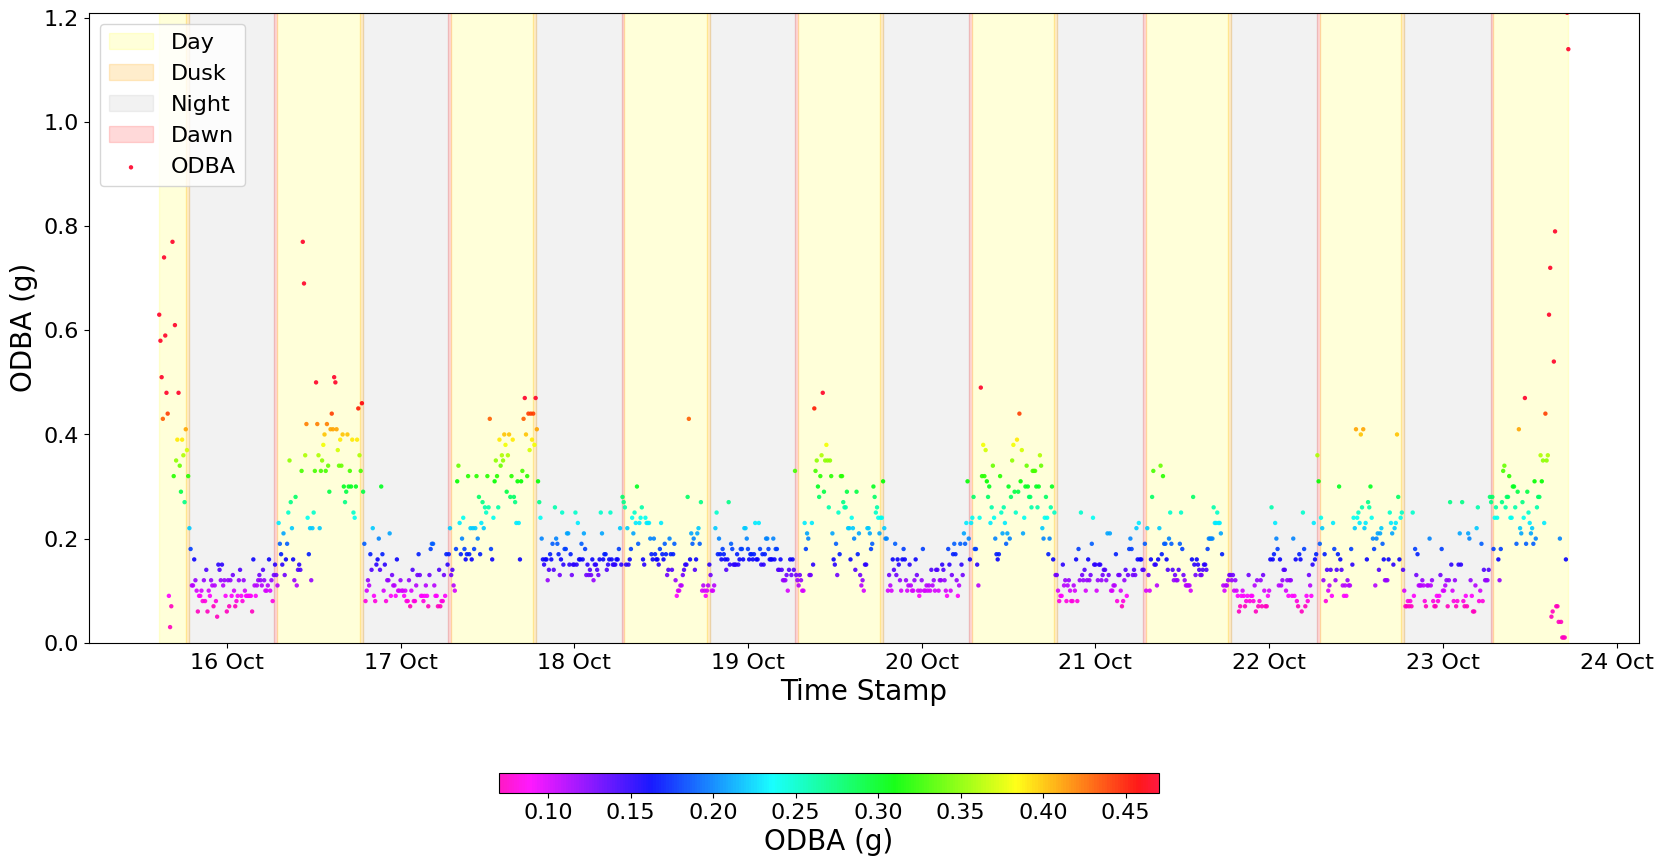

In [8]:
# Define color map and normalization based on percentiles of ODBA values
cmap = plt.get_cmap('gist_rainbow').reversed()
lower_percentile = 2
upper_percentile = 98
lower_bound = odba_data['ODBA (g)'].quantile(lower_percentile / 100)
upper_bound = odba_data['ODBA (g)'].quantile(upper_percentile / 100)
norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)

# Ensure 'Date' column exists in odba_data
odba_data['Date'] = odba_data['Time Stamp'].dt.date

# Calculate sun_cycles
sun_cycles = {current_date: calculate_sun_times(current_date) for current_date in odba_data['Date'].unique()}

# Initialize the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Set y-axis limits
ax.set_ylim(0, max(odba_data['ODBA (g)']))

# Plot day-night bands using the sun_cycles data
plot_day_night_bands(sun_cycles, odba_data, ax)

# Scatter plot with color-coded ODBA values
sc = ax.scatter(odba_data['Time Stamp'], odba_data['ODBA (g)'], s=10, alpha=0.9,
                c=odba_data['ODBA (g)'], cmap=cmap, norm=norm, edgecolor='none', label='ODBA')

# Formatting x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Only add the legend for day/night once
ax.legend(loc='upper left', fontsize=16)

# Set plot titles and labels
ax.set_xlabel('Time Stamp', fontsize=20)
ax.set_ylabel('ODBA (g)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

# Create color bar
colorbar_axes = fig.add_axes([0.33, 0.1, 0.33, 0.02])
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')
cbar.set_label('ODBA (g)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.subplots_adjust(bottom=0.25)
plt.show()